In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from sklearn.neighbors import KNeighborsRegressor
import torch
from scipy.stats import kurtosis,skew

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={ 3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                }
                ,
                 2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
               
                
              ,6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                },
               
                }
test = {1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
},}
appliances = ["Refrigerator"]

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    x_train_mean = []
    x_train_std = []
    x_train_max_min = []
    x_train_main = []
    x_train_main_dif = []
    x_train_max = []
    x_train_min = []
    x_train_kurtosis = []
    x_train_skew = []
    n = 99
    m = 9
    units_to_pad = n // 2
    units_to_pad1 = m//2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    scaler_mean = StandardScaler()
    scaler_std = StandardScaler()
    scaler_max_min = StandardScaler()
    scaler_main = StandardScaler()
    scaler_diff = StandardScaler()
    scaler_max = StandardScaler()
    scaler_min = StandardScaler()
    scaler_kurtosis = StandardScaler()
    scaler_skew = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values

        # x_diff = x
        # for i in range(1,len(x)):
        #     x_diff[i] = x_diff[i] - x_diff[i-1]

        x_train_main.extend(x)
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x2 = x
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        # print(0)
        x_train_mean.extend(jnp.mean(x, axis=1))
        # print(0)
        x_train_std.extend(jnp.std(x, axis=1))
        x1 = jnp.pad(x2, (units_to_pad1, units_to_pad1),
                    'constant', constant_values=(0, 0))
        x1 = jnp.array([x1[i: i + m] for i in range(len(x1) - m + 1)])
        x_train_max_min.extend(jnp.max(x, axis=1)-jnp.min(x,axis=1))
        x_train_max.extend(jnp.max(x1, axis = 1))
        x_train_min.extend(jnp.min(x1, axis = 1))
        x_train_kurtosis.extend(kurtosis(x,axis=1))
        x_train_skew.extend(skew(x,axis = 1))
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))
        # x_train_diff.extend(x_diff)

    # for i in range(1,len(x_train)):
    #     x_train[i] = x_train[i] - x_train[i-1]
    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train_main = jnp.array(x_train_main).reshape(-1,1)
    x_train_mean = jnp.array(x_train_mean).reshape(-1,1)
    x_train_std =  jnp.array(x_train_std).reshape(-1,1)
    x_train_max_min =  jnp.array(x_train_max_min).reshape(-1,1)
    x_train_max =  jnp.array(x_train_max).reshape(-1,1)
    x_train_skew = jnp.array(x_train_skew).reshape(-1,1)
    x_train_min =  jnp.array(x_train_min).reshape(-1,1)
    x_train_kurtosis = jnp.array(x_train_kurtosis).reshape(-1,1)
    # x_train_diff =  jnp.array(x_train_diff).reshape(-1,1)
   


    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)
    x_train_main = scaler_main.fit_transform(x_train_main)
    x_train_mean = scaler_mean.fit_transform(x_train_mean)
    x_train_std = scaler_std.fit_transform(x_train_std)
    x_train_max_min = scaler_max_min.fit_transform(x_train_max_min)
    x_train_max = scaler_max.fit_transform(x_train_max)
    x_train_min = scaler_min.fit_transform(x_train_min)
    x_train_kurtosis = scaler_kurtosis.fit_transform(x_train_kurtosis)
    x_train_skew = scaler_skew.fit_transform(x_train_skew)
    # x_train_diff = scaler_diff.fit_transform(x_train_diff)

    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_mean = []
    x_test_std = []
    x_test_max_min = []
    x_test_timestamp_true =[]
    x_test_main = []
    x_test_max = []
    x_test_min = []
    x_test_kurtosis = []
    x_test_skew = []

    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values 
        # x = x - 100
        # x_diff = x
        # for i in range(1,len(x)):
        #     x_diff[i] = x_diff[i] - x_diff[i-1]
        x_test_main.extend(x)
        y = df[appliances[0]].values

        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x2 = x
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])

        x_test_mean.extend(jnp.mean(x, axis=1))
        x_test_std.extend(jnp.std(x, axis=1))
        x1 = jnp.pad(x2, (units_to_pad1, units_to_pad1),
                    'constant', constant_values=(0, 0))
        x1 = jnp.array([x1[i: i + m] for i in range(len(x1) - m + 1)])
        x_test_max_min.extend(jnp.max(x, axis=1)-jnp.min(x, axis=1))
        x_test_max.extend(jnp.max(x1, axis=1))
        x_test_min.extend(jnp.min(x1, axis=1))
        x_test.extend(x)
        x_test_kurtosis.extend(kurtosis(x,axis=1))
        x_test_skew.extend(skew(x,axis=1))
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)
        # x_test_diff.extend(x_diff)

    # for i in range(1,len(x_test)):
    #     x_test[i] = x_test[i] - x_test[i-1]
    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)
    x_test_main = jnp.array(x_test_main).reshape(-1,1)
    x_test_mean = jnp.array(x_test_mean).reshape(-1,1)
    x_test_std =  jnp.array(x_test_std).reshape(-1,1)
    x_test_max_min =  jnp.array(x_test_max_min).reshape(-1,1)
    x_test_max = jnp.array(x_test_max).reshape(-1,1)
    x_test_min = jnp.array(x_test_min).reshape(-1,1)
    x_test_kurtosis = jnp.array(x_test_kurtosis).reshape(-1,1)
    x_test_skew = jnp.array(x_test_skew).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
    x_test_mean = scaler_mean.transform(x_test_mean)
    x_test_std = scaler_std.transform(x_test_std)
    x_test_max_min = scaler_max_min.transform(x_test_max_min)
    x_test_main = scaler_main.transform(x_test_main)
    x_test_max =  scaler_max.transform(x_test_max)
    x_test_min = scaler_min.transform(x_test_min)
    x_test_kurtosis = scaler_kurtosis.transform(x_test_kurtosis)
    x_test_skew = scaler_skew.transform(x_test_skew)
    # x_test_diff = scaler_diff.transform(x_test_diff)
#     y_test = scaler_y.transform(y_test)

    # x_train_features = x_train_main_dif
    # x_test_features = x_test_main_dif

    x_train = jnp.array(x_train[:,1:]).reshape(x_train.shape[0], n-1)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test[:,1:]).reshape(x_test.shape[0], n-1)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    #x_train_std, 
    #, x_test_std, x_test_max_min,
    num_features_selected = 6
    x_train_features = jnp.concatenate((x_train_main, x_train_mean,  x_train_max_min,x_train_max, x_train_min, x_train_kurtosis), axis=1).reshape(x_train.shape[0], num_features_selected)
    x_test_features = jnp.concatenate((x_test_main, x_test_mean,  x_test_max_min, x_test_max, x_test_min,  x_test_kurtosis), axis=1).reshape(x_test.shape[0], num_features_selected)

    scalers = np.array([scaler_x, scaler_y, scaler_time, scaler_main, scaler_mean, scaler_std, scaler_max_min, scaler_max, scaler_min, scaler_kurtosis, scaler_skew])
    return x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timestamp, x_test_timestamp, scalers, x_test_main


In [6]:
x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timstamp, x_test_timestamp, scalers, x_test_main = dataset_load(appliances, train, test)

In [7]:
x_train_diff = x_train_features[:,0]
diff = np.array(x_train_diff)
for i in range(1, len(x_train_diff)):
		value = x_train_diff[i] - x_train_diff[i - 1]
		diff[i] = value

x_test_diff = x_test_features[:,0]
diff = np.array(x_test_diff)
for i in range(1, len(x_test_diff)):
		value = x_test_diff[i] - x_test_diff[i - 1]
		diff[i] = value

# x_train_zeros = np.zeros(x_train_diff.shape)
# x_test_zeros = np.zeros(x_test_diff.shape)

In [8]:
x_train_features = np.concatenate((np.array(x_train_features), (np.array(x_train_diff.reshape(-1,1)))), axis=1)
x_test_features = np.concatenate((np.array(x_test_features), (np.array(x_test_diff.reshape(-1,1)))), axis=1)

In [9]:
# import gpytorch
indexes = 53456
n = 7
x = np.array(x_train_features).astype('float64')
y = (np.array(y_train)).reshape(-1,).astype('float64')
xt = np.array(x_test_features).astype('float64')
yt = (np.array(y_test)).reshape(-1,).astype('float64')

if x.shape[0]>indexes:
  x = x[:indexes]
  y = y[:indexes]

In [10]:
x.dtype

dtype('float64')

In [11]:
x.shape, y.shape, xt.shape, yt.shape

((50320, 7), (50320,), (19917, 7), (19917,))

In [12]:
neigh = KNeighborsRegressor(n_neighbors=199)
neigh.fit(x, y)

KNeighborsRegressor(n_neighbors=199)

In [13]:
y_pred = neigh.predict(xt)

In [14]:
y_mean = scalers[1].inverse_transform(y_pred.reshape(-1,1)).squeeze()

In [15]:
y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

<AxesSubplot:ylabel='Density'>

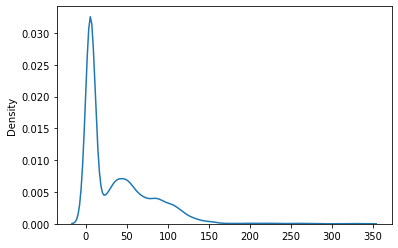

In [16]:
mae_arr = np.abs(np.array(yt) - y_mean)
sns.kdeplot(mae_arr)

In [17]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  37.22615422131573
RMSE:  55.20108


In [18]:
x1 = x_test_features[:,0].reshape(-1,1)

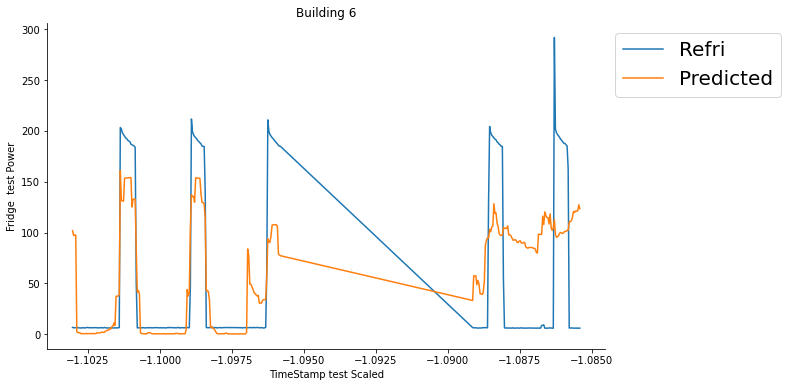

In [19]:
idx = 300 #x2.shape[0]
start = 0
plt.figure(figsize=(10,6))
# plt.plot(x_test_timestamp[start:start+idx], scalers[3].inverse_transform(x1)[start:start+idx], label = "Main")
# plt.plot(x_test_timestamp[:idx], scalers[-1].inverse_transform(x2)[:idx], label = "Main Ref Dif")
plt.plot(x_test_timestamp[start:start+idx], yt[start:start+idx], label = "Refri")
plt.plot(x_test_timestamp[start:start+idx], y_mean[start:start+idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
plt.title("Building 6")
sns.despine()

In [20]:
y_mean1 = np.array(y_mean)
for i in range(len(y_mean)):

  # if y_mean1[i]>80 and y_mean[i]<120:
  if y_mean[i]>150:
    y_mean1[i] = 145
  if y_mean1[i]<100 and y_mean1[i]>50:
    y_mean1[i] = 145
  if y_mean1[i]<50:
      y_mean1[i] = 0
  # if y_mean[i]>160:
  #   y_mean1[i] = 155

  # if y_mean1[i]<160 and y_mean1[i]>50:
  #   y_mean1[i] = 155

  # if y_mean1[i]<50:
  #   y_mean1[i] = 0

In [21]:
mae = np.mean(np.abs(np.array(yt) - y_mean1))
rms = errors.rmse(jnp.array(yt), y_mean1)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  42.98315931812185
RMSE:  67.648


In [24]:
# Building 6: MAE:29.405, 24.524
#building 5: MAE:44.595, 40...
# building 2: MAE:31.6, 30.579
# building 3: MAE:35.159
# building 1: MAE:37.22615